In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

test_participant = 20

In [100]:
data = pd.read_csv('../Collected Data/preprocessed/'+str(test_participant)+'/preprocessed_traindata.csv')

X = data.drop('Label', axis=1) #features
y = data['Label']
y = y.str.strip()
len(X)
X.tail()


,avg_accX,min_accX,max_accX,var_accX,std_accX,avg_accY,min_accY,max_accY,var_accY,std_accY,...,avg_pressure,min_pressure,max_pressure,var_pressure,range_pressure,std_pressure,slope_pressure,kurtosis_pressure,Interqartile_percentage_Pressure,skew_pressure
7765,-0.773865,-1.334839,-0.460693,0.034093,0.184180,0.010675,-0.305542,0.178467,0.013334,0.115183,...,974.562696,974.305675,974.941654,0.022076,0.635979,0.148209,0.000264,0.056936,0.189799,0.609047
7766,-0.802524,-1.200439,-0.459473,0.032913,0.180966,0.056221,-0.144409,0.205200,0.008546,0.092214,...,974.801238,974.589560,975.141330,0.014732,0.551770,0.121074,0.000439,0.798906,0.149817,0.756359
7767,-0.065311,-1.114380,0.796143,0.460808,0.674776,0.339815,-0.041260,1.050781,0.110099,0.329831,...,975.047464,974.783900,975.285295,0.017133,0.501395,0.130110,0.003139,-0.713406,0.190609,0.092571
7768,-0.101199,-0.367554,0.250977,0.054057,0.231755,-0.006255,-0.217163,0.222290,0.006255,0.078838,...,974.337777,974.049544,974.714518,0.039974,0.664974,0.199294,-0.003342,-1.027596,0.310558,0.442752
7769,-0.263720,-0.287964,-0.250610,0.000082,0.009005,0.048271,-0.012573,0.079590,0.001198,0.034459,...,974.344251,974.235140,974.404892,0.001170,0.169752,0.034056,0.000349,0.286911,0.035707,-0.506659


In [101]:
label_encoder = LabelEncoder()

encoded_traininglabels = label_encoder.fit_transform(y)

print("Encoded Labels:", encoded_traininglabels)

Encoded Labels: [0 0 0 ... 4 0 0]


In [102]:
label_mapping = dict(zip(encoded_traininglabels, y))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'Null', 1: 'lift down', 4: 'stairs down', 5: 'stairs up', 2: 'lift up', 3: 'null'}


In [103]:
y = encoded_traininglabels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [104]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 225, 250, 275, 300],  # Testing different values for n_estimators
    'max_depth': [None,5, 10, 15, 20],       # Testing different values for max_depth
}

# Initializing Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Perform grid search to find the best hyperparameters
grid_search.fit(X,y)

# Get the best model and best parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)


Best Parameters: {'max_depth': 10, 'n_estimators': 225}


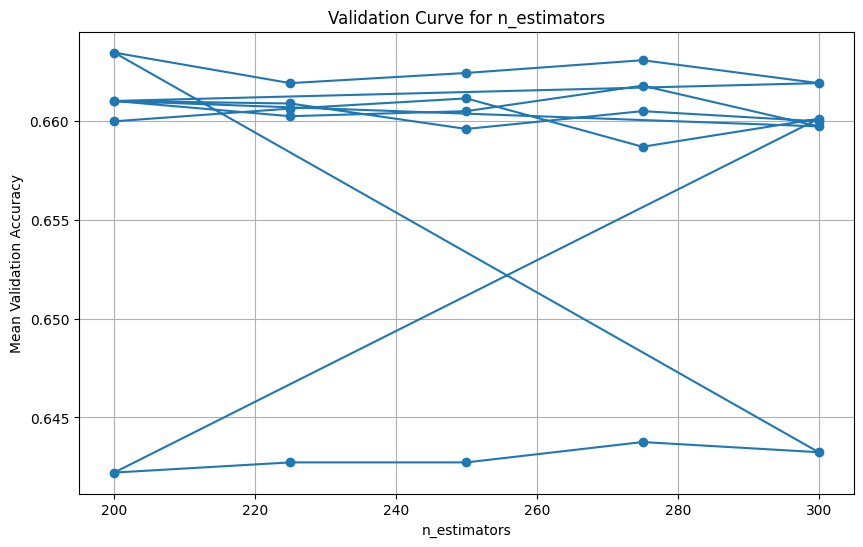

In [88]:
import matplotlib.pyplot as plt

# Extract and plot mean validation scores
mean_scores = grid_search.cv_results_['mean_test_score']
params_n_estimators = [param['n_estimators'] for param in grid_search.cv_results_['params']]

plt.figure(figsize=(10, 6))
plt.plot(params_n_estimators, mean_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Validation Accuracy')
plt.title('Validation Curve for n_estimators')
plt.grid(True)
plt.show()


In [89]:
# Training the model using the best parameters
final_rf = RandomForestClassifier(**best_params, random_state=42)
final_rf.fit(X,y)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [90]:

y_pred = final_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8410553410553411


In [91]:
data = pd.read_csv('../Collected Data/preprocessed/'+str(test_participant)+'/preprocessed_testdata.csv')

xtest = data.drop('Label', axis=1) #features
ytest = data['Label']

In [92]:
encoded_testinglabels = label_encoder.fit_transform(ytest)
label_mapping = dict(zip(encoded_testinglabels, ytest))
print("Label Mapping:", label_mapping)
print(encoded_testinglabels)

Label Mapping: {0: 'Null', 1: 'lift down', 4: 'stairs up', 3: 'stairs down', 2: 'lift up'}
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 4 4 4 4 0 0 0 0 0 0 0
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 2 2 2 2 2 2
 2 2 2 2 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0
 4 4 4 4 4 4 4 4 4 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2
 2 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 3 3 3 3 3 3
 3 3 3 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 3 3 3 3 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 

In [93]:
y_pred = final_rf.predict(xtest)
ytest = encoded_testinglabels
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5973451327433629


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [95]:
import numpy as np
cm = confusion_matrix(ytest, y_pred,  labels=np.arange(len(label_encoder.classes_)))

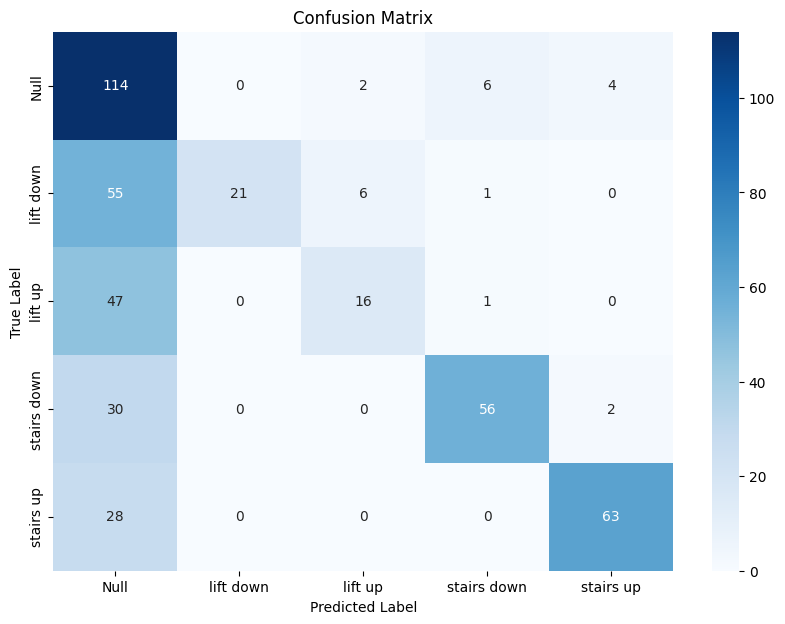

In [96]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [97]:
importances = final_rf.feature_importances_

# Create a DataFrame for better visualization
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

In [98]:
feature_importances

,Feature,Importance
26,slope_pressure,0.197704
18,var_magnitude,0.078442
19,std_magnitude,0.074197
17,max_magnitude,0.049939
16,min_magnitude,0.036031
28,Interqartile_percentage_Pressure,0.033042
3,var_accX,0.031683
4,std_accX,0.031050
14,std_accZ,0.027879
13,var_accZ,0.027606
